In [47]:
import pandas as pd

feedback= pd.read_csv("assets/data/feedback_data.csv")
benefits= pd.read_csv("assets/data/benefits_data.csv")

def clean(df):
    print(df.shape)
    print(df.columns)
    print(df.duplicated().sum())
    df.drop_duplicates(inplace=True)
    print(df.shape)
    print(df.isna().sum())

clean(feedback)
clean(benefits)

(30000, 4)
Index(['EmployeeID', 'BenefitID', 'SatisfactionScore', 'Comments'], dtype='object')
624
(29376, 4)
EmployeeID           0
BenefitID            0
SatisfactionScore    0
Comments             0
dtype: int64
(30, 4)
Index(['BenefitID', 'BenefitType', 'BenefitSubType', 'BenefitCost'], dtype='object')
0
(30, 4)
BenefitID         0
BenefitType       0
BenefitSubType    0
BenefitCost       0
dtype: int64


In [48]:
!pip install -qU \
            langchain-openai==0.3.3 \
            langchain==0.3.17 \
            textblob

In [49]:
with open('api.txt', 'r') as file:
    OPENAI_API_KEY = file.read().strip()


In [50]:
df = pd.merge(
    feedback,
    benefits[['BenefitID', 'BenefitType', 'BenefitSubType']],
    on='BenefitID',
    how='left'
)

clean(df)

(29376, 6)
Index(['EmployeeID', 'BenefitID', 'SatisfactionScore', 'Comments',
       'BenefitType', 'BenefitSubType'],
      dtype='object')
0
(29376, 6)
EmployeeID           0
BenefitID            0
SatisfactionScore    0
Comments             0
BenefitType          0
BenefitSubType       0
dtype: int64


In [51]:
print(f"BenefitTypes: {df['BenefitType'].unique()}")
print(f"BenefitSubTypes: {df['BenefitSubType'].unique()}")

BenefitTypes: ['Gym Membership' 'Tuition Reimbursement' 'Commuter Benefits'
 'Life Insurance' 'Retirement Plan' 'Health Insurance'
 'Cell Phone Allowance' 'Flexible Spending Account' 'Wellness Programs'
 'Childcare' 'Professional Development' 'Technology Stipend']
BenefitSubTypes: ['Tier 2 Partners' 'Undergraduate Degree' 'Transit Subsidy'
 'Supplemental Standard' '401k Basic Matching' '401k Investment Fees'
 'Individual Courses' 'Dependent Coverage' 'Basic Coverage'
 'Tier 3 Partners' 'HMO Family' 'PPO Family' '401k Catch-Up Contributions'
 'PPO Individual' 'Monthly Communications' 'HDHP Individual'
 'Healthcare FSA' 'Premium Discount Tier 1' 'After-School Care'
 'Graduate Degree' 'On-Site Infant Care' 'Conference Attendance'
 'Family Membership' 'Monthly Internet Allowance' 'Tier 1 Partners'
 '401k Standard Matching' 'Professional Certification'
 'Supplemental High Amount' '401k Maximum Matching'
 '401k High Contribution']


In [52]:
import os
import pandas as pd
from tqdm import tqdm
from langchain_openai import ChatOpenAI
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from textblob import TextBlob


# LangChain setup
llm = ChatOpenAI(temperature=0, model="gpt-4o-mini", api_key=OPENAI_API_KEY)
parser = StrOutputParser()

# === Load Feedback Data ===
df_normal = df.head(10)  # limit for testing

# === Step 1: Feedback Classification ===
classify_prompt = PromptTemplate.from_template("""
Classify the following employee comment into **one of the categories** below.
Also consider specific benefit types and subtypes mentioned, such as Gym Membership, Tuition Reimbursement, Health Insurance, etc.

Choose ONLY ONE category from the list:

1. Process Issues — Problems with how a benefit is applied for, claimed, or managed (e.g., reimbursement delays)
2. Coverage Issues — Complaints about what is or isn’t covered under the benefit plan
3. Benefit Value — Perceptions about whether the benefit is worth it or meets employee needs
4. Enrollment & Access Issues — Difficulty enrolling, accessing, or navigating benefit platforms
5. Communication & Clarity — Confusion due to unclear terms, poor documentation, or lack of information
6. Provider Specific Complaints — Complaints aimed at third-party providers (e.g., gym partners, HMO networks)
7. Other  — Does not clearly fit in the above categories

Respond with only the category name.

Comment: {comments}
BenefitType: {BenefitType}
BenefitSubType: {BenefitSubType}
""")

classify_chain = classify_prompt | llm | parser

# === Step 2: Action Identification ===
action_prompt = PromptTemplate.from_template("""
Given the comment,benefittype, benefitsubtype, category, sentiment, and severity, determine if this issue requires action.
If yes, summarize the action briefly in a sentence or less.

Comment: {comments}
BenefitType: {BenefitType}
BenefitSubType: {BenefitSubType}
Category: {category}
Sentiment: {sentiment}
Severity: {severity}

Return:
Actionable: Yes/No
Suggested Action: <action or 'None'>
""")
action_chain = action_prompt | llm | parser

# === Step 3: Task Routing ===
route_prompt = PromptTemplate.from_template("""
Route this issue to the correct department and assign a priority level.

Inputs:
- Category: {category}
- BenefitType: {BenefitType}
- BenefitSubType: {BenefitSubType}
- Suggested Action: {suggested_action}
- Severity: {severity}

Output format:
Department: <department>
Priority: <High/Medium/Low>
""")
route_chain = route_prompt | llm | parser


# === Step 4: Issue Summary ===
issue_summary_prompt = PromptTemplate.from_template("""
Summarize the employee's issue clearly and concisely in one sentence, using the inputs below.

Comment: {comments}
BenefitType: {BenefitType}
BenefitSubType: {BenefitSubType}
Category: {category}
Sentiment: {sentiment}
Severity: {severity}
Suggested Action: {suggested_action}

Return:
<One-sentence issue summary>
""")
issue_summary_chain = issue_summary_prompt | llm | parser


# === Sentiment Analysis using TextBlob ===
def analyze_sentiment(comment: str):
    try:
        if not comment or not isinstance(comment, str):
            return "Neutral", 3  # Default fallback

        blob = TextBlob(comment)
        polarity = blob.sentiment.polarity  # Ranges from -1 to 1
        subjectivity = blob.sentiment.subjectivity  # Ranges from 0 to 1

        # Sentiment label
        if polarity >= 0.3:
            sentiment = "Positive"
        elif polarity <= -0.3:
            sentiment = "Negative"
        else:
            sentiment = "Neutral"

        # Granular severity mapping
        if polarity >= 0.6:
            severity = 1  # Very positive
        elif polarity >= 0.3:
            severity = 2  # Mild positive
        elif polarity > -0.3:
            severity = 3  # Neutral
        elif polarity > -0.6:
            severity = 4  # Mild negative
        else:
            severity = 5  # Very negative

        # Adjust for very vague/unopinionated comments
        if subjectivity < 0.2 and sentiment == "Neutral":
            severity = 2  # Informational, not severe

        return sentiment, severity

    except Exception as e:
        print(f"[Sentiment Error]: {e}")
        return "Neutral", 3


# === Process Each Feedback Comment ===
results = []
import time
start_time= time.time()
for _, row in tqdm(df_normal.iterrows(), total=len(df_normal)):
    comment = row["Comments"]
    employee_id = row["EmployeeID"]
    benefit_id = row["BenefitID"]
    BenefitType = row['BenefitType']
    BenefitSubType = row['BenefitSubType']
    # Step 1: Category Classification
    category = classify_chain.invoke({
        "comments": comment,
        "BenefitType": BenefitType,
        "BenefitSubType": BenefitSubType}).strip()

    # Step 2: Sentiment Analysis (local NLP)
    sentiment, severity = analyze_sentiment(comment)

    # Step 3: Action Identification
    action_output = action_chain.invoke({
        "comments": comment,
        "BenefitType": BenefitType,
        "BenefitSubType": BenefitSubType,
        "category": category,
        "sentiment": sentiment,
        "severity": severity
    })
    actionable, suggested_action = "No", "None"
    if "Actionable:" in action_output:
        parts = action_output.split("Suggested Action:")
        actionable = parts[0].split(":")[1].strip()
        suggested_action = parts[1].strip() if len(parts) > 1 else "None"

    # Step 4: Task Routing
    route_output = route_chain.invoke({
        "category": category,
        "BenefitType": BenefitType,
        "BenefitSubType": BenefitSubType,
        "suggested_action": suggested_action,
        "severity": severity
    })
    try:
        lines = route_output.split("\n")
        department = lines[0].split(":")[1].strip()
        priority = lines[1].split(":")[1].strip()
    except:
        department = "Unknown"
        issue_summary = "Parsing error"
        priority = "Medium"

    # Step 5: Generate Issue Summary
    issue_summary = issue_summary_chain.invoke({
        "comments": comment,
        "BenefitType": BenefitType,
        "BenefitSubType": BenefitSubType,
        "category": category,
        "sentiment": sentiment,
        "severity": severity,
        "suggested_action": suggested_action
    }).strip()

    # Add to results
    results.append({
        "EmployeeID": employee_id,
        "BenefitID": benefit_id,
        "Comments": comment,
        "BenefitType": BenefitType,
        "BenefitSubType": BenefitSubType,
        "Category": category,
        "Sentiment": sentiment,
        "Severity": severity,
        "Actionable": actionable,
        "SuggestedAction": suggested_action,
        "Department": department,
        "Priority": priority,
        "IssueSummary": issue_summary
    })
end_time= time.time()
print(f"The Time Difference to run normally: {end_time- start_time}")
# Save final results
results_df = pd.DataFrame(results)
results_df.to_csv("feedback_chained_output.csv", index=False)
print("✅ Processed feedback saved to 'feedback_chained_output.csv'.")


100%|██████████| 10/10 [00:23<00:00,  2.36s/it]

The Time Difference to run normally: 23.6418879032135
✅ Processed feedback saved to 'feedback_chained_output.csv'.


In [ ]:
from langchain_core.runnables import RunnableParallel
from concurrent.futures import ThreadPoolExecutor, as_completed
import pandas as pd
import time
import os

# Set up your chains
parallel_chain = RunnableParallel({
    "Category": classify_chain,
    "ActionResult": action_chain,
    "Routing": route_chain,
    "IssueSummary": issue_summary_chain
})

SAVE_INTERVAL = 1000  # Save after every 100 rows
OUTPUT_FILE = "feedback_parallel_output_iter2.csv"

# === Robust Row Processor ===
def process_row_parallel(row):
    try:
        comment = row["Comments"]
        employee_id = row["EmployeeID"]
        benefit_id = row["BenefitID"]
        BenefitType = row["BenefitType"]
        BenefitSubType = row["BenefitSubType"]

        # Step 1: Sentiment
        sentiment, severity = analyze_sentiment(comment)

        input_dict = {
            "comments": comment,
            "BenefitType": BenefitType,
            "BenefitSubType": BenefitSubType,
            "sentiment": sentiment,
            "severity": severity,
            "category": "Unknown",
            "suggested_action": "None"
        }

        # Step 2: Classify (separate try to isolate LLM failure)
        try:
            category = classify_chain.invoke({
                "comments": comment,
                "BenefitType": BenefitType,
                "BenefitSubType": BenefitSubType
            }).strip()
            input_dict["category"] = category
        except Exception as e:
            return {"EmployeeID": employee_id, "Error": f"Category error: {e}"}

        # Step 3: Run all in parallel
        try:
            output = parallel_chain.invoke(input_dict)
        except Exception as e:
            return {"EmployeeID": employee_id, "Error": f"Parallel chain error: {e}"}

        # Parse ActionResult
        action_output = output.get("ActionResult", "")
        actionable, suggested_action = "No", "None"
        if "Actionable:" in action_output:
            parts = action_output.split("Suggested Action:")
            actionable = parts[0].split(":")[1].strip()
            suggested_action = parts[1].strip() if len(parts) > 1 else "None"
        input_dict["suggested_action"] = suggested_action

        # Re-run dependent chains
        try:
            routing_result = route_chain.invoke(input_dict)
            lines = routing_result.split("\n")
            department = lines[0].split(":")[1].strip() if len(lines) > 0 else "Unknown"
            priority = lines[1].split(":")[1].strip() if len(lines) > 1 else "Medium"
        except Exception as e:
            department, priority = "Unknown", "Medium"

        try:
            issue_summary = issue_summary_chain.invoke(input_dict).strip()
        except Exception as e:
            issue_summary = "Summary generation error"

        return {
            "EmployeeID": employee_id,
            "BenefitID": benefit_id,
            "Comments": comment,
            "BenefitType": BenefitType,
            "BenefitSubType": BenefitSubType,
            "Category": category,
            "Sentiment": sentiment,
            "Severity": severity,
            "Actionable": actionable,
            "SuggestedAction": suggested_action,
            "Department": department,
            "Priority": priority,
            "IssueSummary": issue_summary
        }

    except Exception as e:
        return {"EmployeeID": row.get("EmployeeID", "Unknown"), "Error": f"Fatal row error: {e}"}


df_parallel = df
rows = [row for _, row in df_parallel.iterrows()]
results = []

start = time.time()

try:
    with ThreadPoolExecutor(max_workers=10) as executor:
        futures = [executor.submit(process_row_parallel, row) for row in rows]
        for i, future in enumerate(tqdm(as_completed(futures), total=len(futures))):
            result = future.result()
            results.append(result)

            # Save checkpoint every N rows
            if i % SAVE_INTERVAL == 0 and i > 0:
                checkpoint_df = pd.DataFrame(results)
                checkpoint_df.to_csv(OUTPUT_FILE, index=False)
                print(f"🔸 Checkpoint saved at row {i}")

except Exception as e:
    print(f"❌ Parallel processing failed: {e}")
    # Save whatever was done so far
    pd.DataFrame(results).to_csv(OUTPUT_FILE, index=False)
    print("⚠️ Partial results saved after crash.")

end = time.time()
print(f"⏱️ Time Taken: {end - start:.2f} seconds")

# Final save
pd.DataFrame(results).to_csv(OUTPUT_FILE, index=False)
print("✅ Final results saved.")


In [ ]:
from langchain_core.runnables import RunnableParallel

parallel_chain = RunnableParallel({
    "Category": classify_chain,
    "ActionResult": action_chain,
    "Routing": route_chain,
    "IssueSummary": issue_summary_chain
})


def process_row_parallel(row):
    try:
        comment = row["Comments"]
        employee_id = row["EmployeeID"]
        benefit_id = row["BenefitID"]
        BenefitType = row["BenefitType"]
        BenefitSubType = row["BenefitSubType"]

        sentiment, severity = analyze_sentiment(comment)

        input_dict = {
            "comments": comment,
            "BenefitType": BenefitType,
            "BenefitSubType": BenefitSubType,
            "sentiment": sentiment,
            "severity": severity,
            "category": "Unknown",           # Needed by action_chain
            "suggested_action": "None"       # Needed by route_chain & summary
        }

        # Classify first to get category
        category = classify_chain.invoke({
            "comments": comment,
            "BenefitType": BenefitType,
            "BenefitSubType": BenefitSubType
        }).strip()
        input_dict["category"] = category

        # Now run the rest in parallel
        output = parallel_chain.invoke(input_dict)

        # Parse action result
        action_output = output.get("ActionResult", "")
        actionable, suggested_action = "No", "None"
        if "Actionable:" in action_output:
            parts = action_output.split("Suggested Action:")
            actionable = parts[0].split(":")[1].strip()
            suggested_action = parts[1].strip() if len(parts) > 1 else "None"

        # Update for final prompt pieces
        input_dict["suggested_action"] = suggested_action

        # Re-run route and summary with full data
        routing_result = route_chain.invoke(input_dict)
        issue_summary = issue_summary_chain.invoke(input_dict)

        # Parse routing
        lines = routing_result.split("\n")
        department = lines[0].split(":")[1].strip() if len(lines) > 0 else "Unknown"
        priority = lines[1].split(":")[1].strip() if len(lines) > 1 else "Medium"

        return {
            "EmployeeID": employee_id,
            "BenefitID": benefit_id,
            "Comments": comment,
            "BenefitType": BenefitType,
            "BenefitSubType": BenefitSubType,
            "Category": category,
            "Sentiment": sentiment,
            "Severity": severity,
            "Actionable": actionable,
            "SuggestedAction": suggested_action,
            "Department": department,
            "Priority": priority,
            "IssueSummary": issue_summary.strip()
        }

    except Exception as e:
        return {"Error": str(e)}

df_parallel = df
rows = [row for _, row in df_parallel.iterrows()]
results = []

import time
start = time.time()
with ThreadPoolExecutor(max_workers=10) as executor:
    futures = [executor.submit(process_row_parallel, row) for row in rows]
    for future in tqdm(as_completed(futures), total=len(futures)):
        result = future.result()
        results.append(result)
end = time.time()
print(f"The Time Taken to run in parallel:  {end- start}")

results_df = pd.DataFrame(results)
results_df.to_csv("feedback_parallel_output.csv", index=False)
print("✅ Done! Results saved.")

 19%|█▉        | 5514/29376 [27:43<1:24:11,  4.72it/s]

### Normal Processing: 
For 25 Feedbacks - 140 Seconds and 5.60 sec / iteration

### Parallel Processing: 
For 50 Feedbacks - 24.7 Seconds and 2.02 sec / iteration

In [ ]:
# from concurrent.futures import ThreadPoolExecutor, as_completed

# def process_row_parallel(row):
#     try:
#         comment = row["Comments"]
#         employee_id = row["EmployeeID"]
#         benefit_id = row["BenefitID"]
#         BenefitType = row["BenefitType"]
#         BenefitSubType = row["BenefitSubType"]

#         # 1. Local sentiment analysis
#         sentiment, severity = analyze_sentiment(comment)

#         # 2. Input to all chains
#         shared_input = {
#             "comments": comment,
#             "BenefitType": BenefitType,
#             "BenefitSubType": BenefitSubType,
#             "sentiment": sentiment,
#             "severity": severity,
#             # suggested_action is not yet known (circular)
#         }
#         from langchain_core.runnables import RunnableParallel

#         parallel_chain = RunnableParallel({
#             "Category": classify_chain,
#             "ActionResult": action_chain,
#             "Routing": route_chain,
#             "IssueSummary": issue_summary_chain
#         })

#         # 3. Run all chains in parallel
#         output = parallel_chain.invoke(shared_input)

#         # Unpack results
#         category = output.get("Category", "Other").strip()
#         action_result = output.get("ActionResult", "").strip()
#         routing_result = output.get("Routing", "").strip()
#         issue_summary = output.get("IssueSummary", "").strip()

#         # Parse Actionable & Suggested Action
#         actionable, suggested_action = "No", "None"
#         if "Actionable:" in action_result:
#             parts = action_result.split("Suggested Action:")
#             actionable = parts[0].split(":")[1].strip()
#             suggested_action = parts[1].strip() if len(parts) > 1 else "None"

#         # Parse Department & Priority
#         department = "Unknown"
#         priority = "Medium"
#         lines = routing_result.split("\n")
#         if len(lines) >= 2:
#             department = lines[0].split(":")[1].strip()
#             priority = lines[1].split(":")[1].strip()

#         return {
#             "EmployeeID": employee_id,
#             "BenefitID": benefit_id,
#             "Comments": comment,
#             "BenefitType": BenefitType,
#             "BenefitSubType": BenefitSubType,
#             "Category": category,
#             "Sentiment": sentiment,
#             "Severity": severity,
#             "Actionable": actionable,
#             "SuggestedAction": suggested_action,
#             "Department": department,
#             "Priority": priority,
#             "IssueSummary": issue_summary
#         }

#     except Exception as e:
#         return {"Error": str(e)}

# df= df.head(50)
# rows = [row for _, row in df.iterrows()]
# results = []

# import time
# start = time.time()
# with ThreadPoolExecutor(max_workers=10) as executor:
#     futures = [executor.submit(process_row_parallel, row) for row in rows]
#     for future in tqdm(as_completed(futures), total=len(futures)):
#         result = future.result()
#         results.append(result)
# end = time.time()
# print(f"The Time Taken to run in parallel:  {end- start}")

# results_df = pd.DataFrame(results)
# results_df.to_csv("feedback_parallel_output.csv", index=False)
# print("✅ Done! Results saved.")



In [ ]:
results_df['Category'].unique()

In [ ]:
results_df['Department'].unique()

In [ ]:
results_df['SuggestedAction'].unique()

### Testing the Generated Parallel Processing Data

In [1]:
import pandas as pd

df= pd.read_csv("feedback_parallel_output.csv")

print(df.shape)
print(df.columns)

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


(29376, 13)
Index(['EmployeeID', 'BenefitID', 'Comments', 'BenefitType', 'BenefitSubType',
       'Category', 'Sentiment', 'Severity', 'Actionable', 'SuggestedAction',
       'Department', 'Priority', 'IssueSummary'],
      dtype='object')


In [2]:
print(f"Unique Categories: {df['Category'].unique()}")
print(f"Unique Sentiments: {df['Sentiment'].unique()}")
print(f"Unique Severity: {df['Severity'].unique()}")
print(f"Unique Actionables: {df['Actionable'].unique()}")
print(f"Unique Departments: {df['Department'].unique()}")
print(f"Unique Priority: {df['Priority'].unique()}")
print("----------------------------------------------------------")
print(f"Unique Count of SuggestedAction: {df['SuggestedAction'].nunique()}")
print(f"Unique Count of IssueSummary: {df['IssueSummary'].nunique()}")

Unique Categories: ['Benefit Value' 'Other' 'Process Issues' 'Provider Specific Complaints'
 'Coverage Issues' 'Enrollment & Access Issues']
Unique Sentiments: ['Positive' 'Neutral' 'Negative']
Unique Severity: [2 1 3 4 5]
Unique Actionables: ['No' 'Yes']
Unique Departments: ['Benefits Administration' 'Human Resources' 'Customer Service'
 'Life Insurance Coverage Department' 'Health Insurance Coverage'
 'Childcare Services' 'Enrollment & Access' 'Retirement Benefits'
 'Professional Development' 'Wellness Programs'
 'Life Insurance Department' 'Health Insurance Coverage Team'
 'Health Insurance Coverage Department' 'Provider Relations' 'IT Support'
 'Finance' 'Life Insurance Coverage Team' 'Commuter Benefits Department'
 'Enrollment & Access Issues' 'Health Insurance Claims'
 'Benefits Management' 'Life Insurance Claims' 'Health Insurance Support'
 'Commuter Benefits Administration']
Unique Priority: ['Medium' 'High']
----------------------------------------------------------
Unique Cou

In [3]:
print(df.isna().sum())

EmployeeID             0
BenefitID              0
Comments               0
BenefitType            0
BenefitSubType         0
Category               0
Sentiment              0
Severity               0
Actionable             0
SuggestedAction    13385
Department             0
Priority               0
IssueSummary           0
dtype: int64


### Heatmap of BenefitType and BenefitSubType Comments Volume

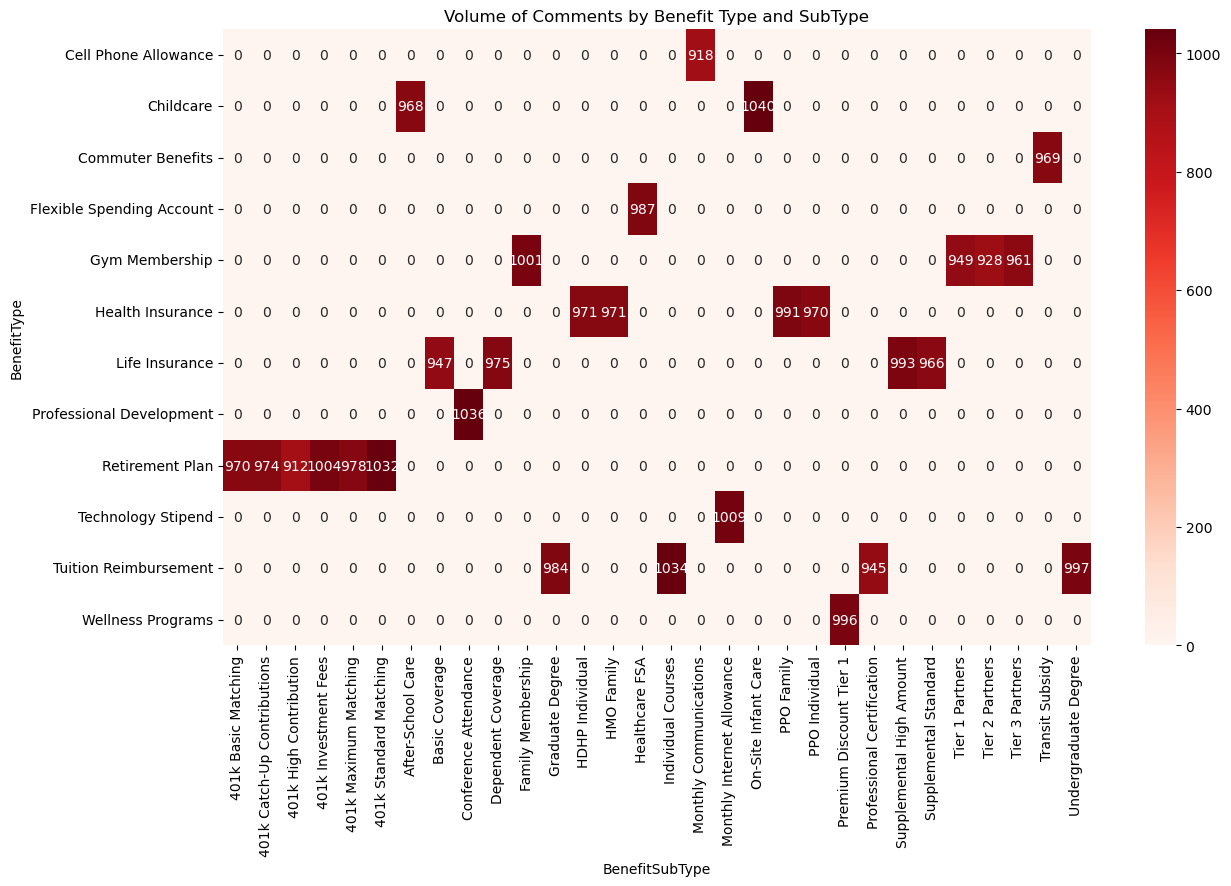

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

pivot = df.pivot_table(index='BenefitType', columns='BenefitSubType', values='EmployeeID', aggfunc='count', fill_value=0)
plt.figure(figsize=(14, 8))
sns.heatmap(pivot, annot=True, fmt="d", cmap="Reds")
plt.title("Volume of Comments by Benefit Type and SubType")
plt.show()


### Top Feedback Categories

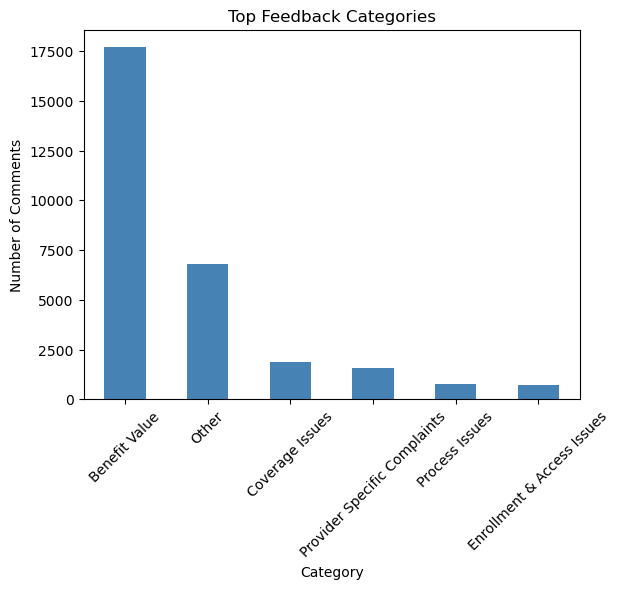

In [5]:
df['Category'].value_counts().plot(kind='bar', color='steelblue')
plt.title("Top Feedback Categories")
plt.xlabel("Category")
plt.ylabel("Number of Comments")
plt.xticks(rotation=45)
plt.show()


### Top Department Categories

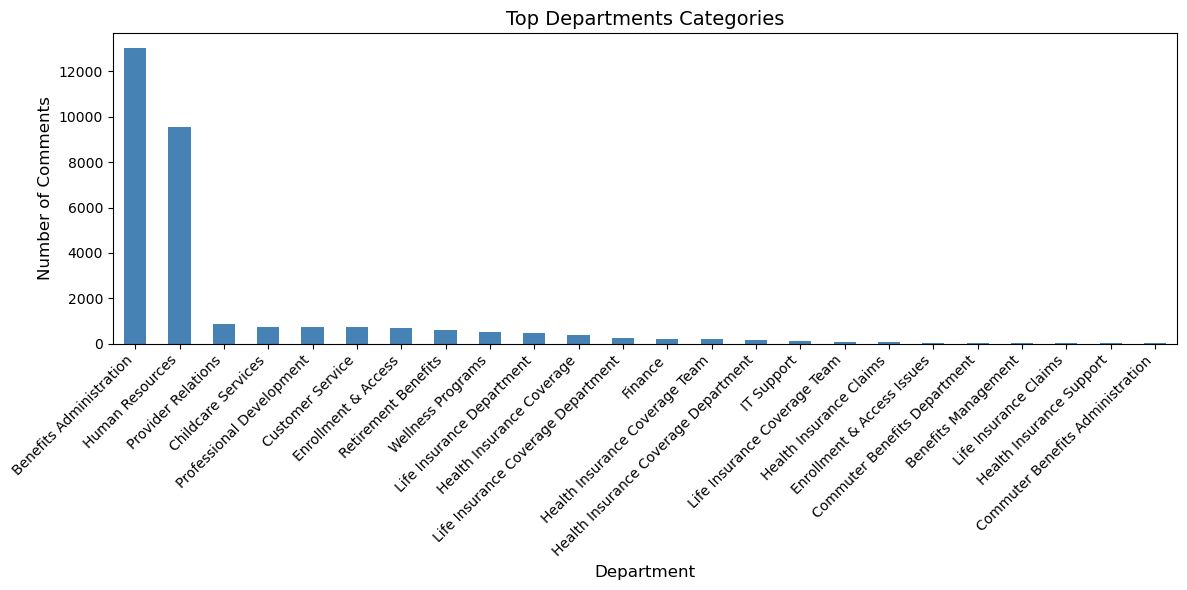

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))  # Increase width and height
df['Department'].value_counts().plot(kind='bar', color='steelblue')
plt.title("Top Departments Categories", fontsize=14)
plt.xlabel("Department", fontsize=12)
plt.ylabel("Number of Comments", fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)  # Rotate and align labels
plt.tight_layout()  # Avoid label cutoff
plt.show()


### Severity by BenefitType

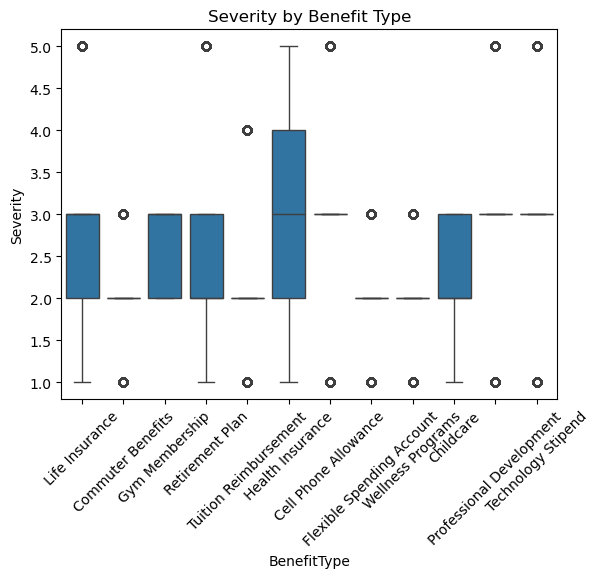

In [6]:
sns.boxplot(x='BenefitType', y='Severity', data=df)
plt.title("Severity by Benefit Type")
plt.xticks(rotation=45)
plt.show()


### Top Benefits and SubTypes with High Severity(>4) Complaints

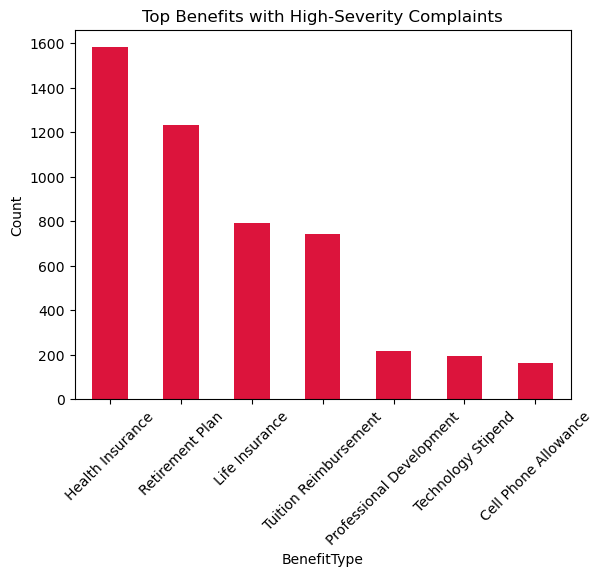

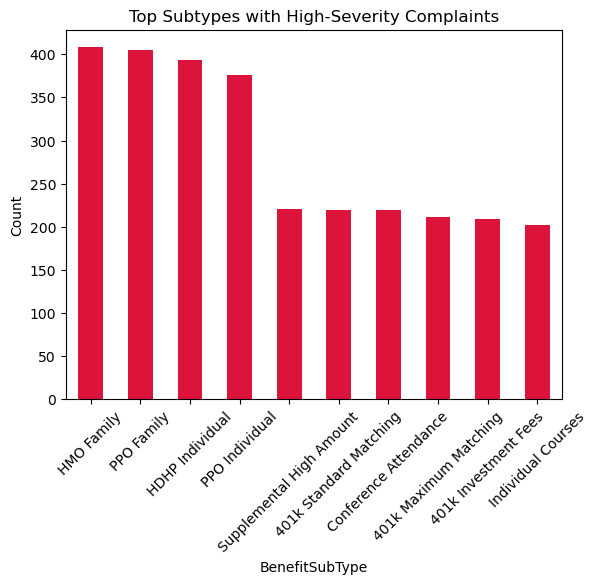

In [24]:
top_types = df[df['Severity'] >= 4]['BenefitType'].value_counts().head(10)
top_types.plot(kind='bar', color='crimson')
plt.title("Top Benefits with High-Severity Complaints")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()



top_subtypes = df[df['Severity'] >= 4]['BenefitSubType'].value_counts().head(10)
top_subtypes.plot(kind='bar', color='crimson')
plt.title("Top Subtypes with High-Severity Complaints")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


### Actionable Feedback by Category

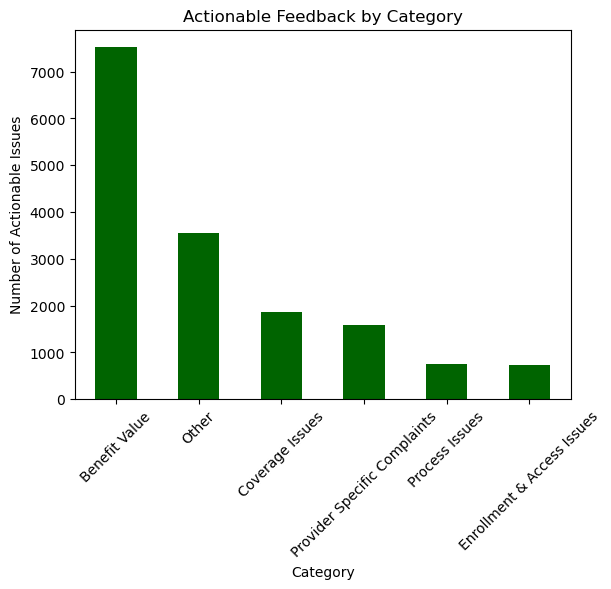

In [8]:
actionable_counts = df[df['Actionable'] == 'Yes']['Category'].value_counts()
actionable_counts.plot(kind='bar', color='darkgreen')
plt.title("Actionable Feedback by Category")
plt.ylabel("Number of Actionable Issues")
plt.xticks(rotation=45)
plt.show()


In [10]:
!pip install wordcloud

### Suggested Actions WordCloud 

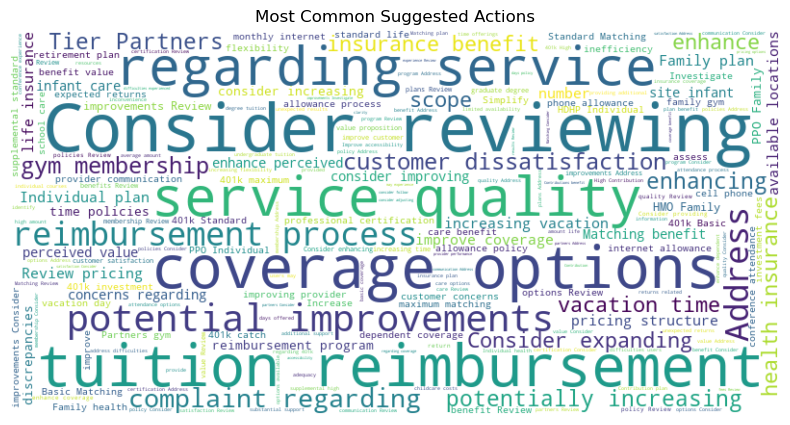

In [11]:
from wordcloud import WordCloud

text = ' '.join(df[df['SuggestedAction'] != 'None']['SuggestedAction'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Common Suggested Actions")
plt.show()


### Raw Comments WordCloud

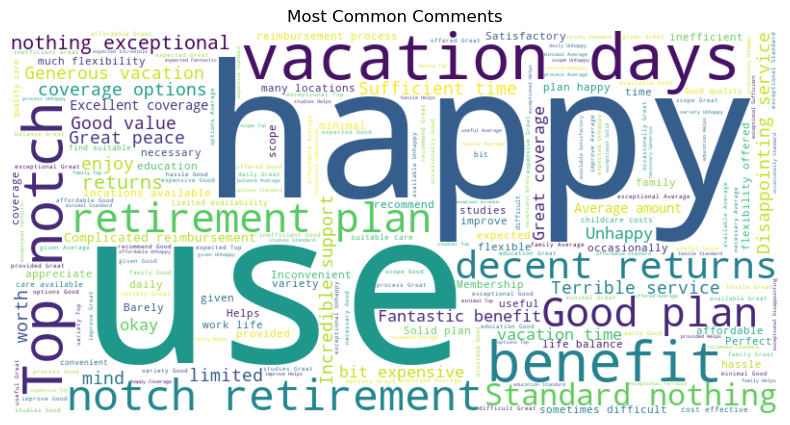

In [12]:
from wordcloud import WordCloud

text = ' '.join(df[df['Comments'] != 'None']['Comments'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilineabr')
plt.axis('off')
plt.title("Most Common Comments")
plt.show()


### Task Priority PieChart

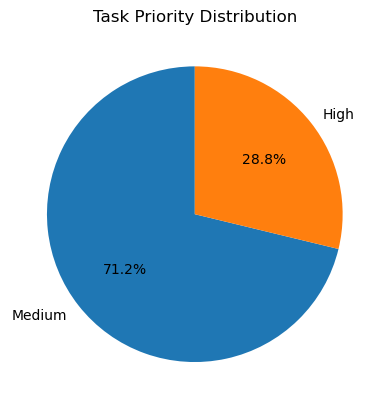

In [13]:
df['Priority'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title("Task Priority Distribution")
plt.ylabel("")
plt.show()


### Sentiment Breakdown by Category

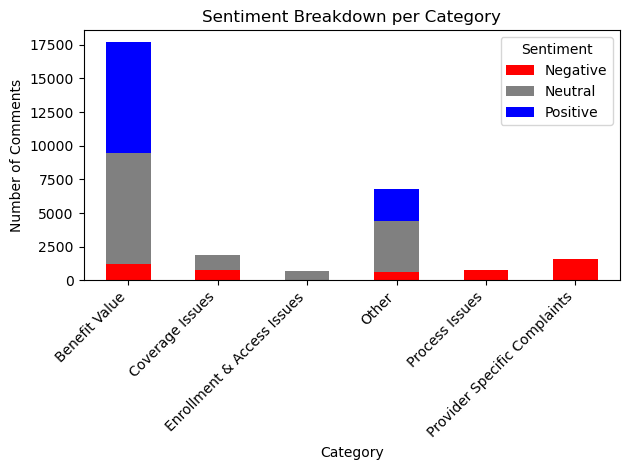

In [29]:
import matplotlib.pyplot as plt

# Prepare the data
category_sentiment = df.groupby(['Category', 'Sentiment']).size().unstack().fillna(0)

# Reorder columns for consistent coloring (if not already sorted)
sentiment_order = ['Negative', 'Neutral', 'Positive']
category_sentiment = category_sentiment.reindex(columns=sentiment_order, fill_value=0)

# Define custom colors
colors = {
    'Negative': 'red',
    'Neutral': 'grey',
    'Positive': 'blue'
}

# Plot
category_sentiment.plot(kind='bar', stacked=True, color=[colors[s] for s in category_sentiment.columns])
plt.title("Sentiment Breakdown per Category")
plt.xlabel("Category")
plt.ylabel("Number of Comments")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


### Aggregating Severity with BenefitSubType and Volume

In [32]:
import numpy as np

# Filter only actionable issues
action_df = df[df['Actionable'] == 'Yes'].copy()

# Step 1: Aggregate key stats per BenefitSubType
agg = action_df.groupby('BenefitSubType').agg(
    Volume=('EmployeeID', 'count'),
    AvgSeverity=('Severity', 'mean'),
    Most_SuggestedAction=('SuggestedAction', lambda x: x.mode().iloc[0] if not x.mode().empty else "None")
).reset_index()

# Optional: Sort by severity and volume
agg = agg.sort_values(by=['AvgSeverity', 'Volume'], ascending=False)

# Display final table
print(agg[['BenefitSubType', 'Volume', 'AvgSeverity', 'Most_SuggestedAction']].to_string(index=False))


             BenefitSubType  Volume  AvgSeverity                                                                                         Most_SuggestedAction
     401k High Contribution     368     4.092391                                     Address the customer's dissatisfaction with the retirement plan benefit.
     401k Standard Matching     411     4.065693                              Address the customer's dissatisfaction with the 401k Standard Matching benefit.
       401k Investment Fees     395     4.058228                       Address the customer's concerns regarding 401k investment fees in the retirement plan.
      401k Maximum Matching     406     4.044335                               Address the customer's dissatisfaction with the 401k maximum matching benefit.
        401k Basic Matching     407     3.992629                                 Address the customer's dissatisfaction with the 401k Basic Matching benefit.
401k Catch-Up Contributions     392     3.974490    

### Aggregating Severity with BenefitType and Volume

In [31]:
import numpy as np

# Filter only actionable issues
action_df = df[df['Actionable'] == 'Yes'].copy()

# Step 1: Aggregate key stats per BenefitSubType
agg = action_df.groupby('BenefitType').agg(
    Volume=('EmployeeID', 'count'),
    AvgSeverity=('Severity', 'mean'),
    Most_SuggestedAction=('SuggestedAction', lambda x: x.mode().iloc[0] if not x.mode().empty else "None")
).reset_index()

# Optional: Sort by severity and volume
agg = agg.sort_values(by=['AvgSeverity', 'Volume'], ascending=False)

# Display final table
print(agg[['BenefitType', 'Volume', 'AvgSeverity', 'Most_SuggestedAction']].to_string(index=False))


              BenefitType  Volume  AvgSeverity                                                                                         Most_SuggestedAction
          Retirement Plan    2379     4.037411                              Address the customer's dissatisfaction with the 401k Standard Matching benefit.
 Professional Development     614     3.713355                           Consider reviewing and enhancing the flexibility of conference attendance options.
       Technology Stipend     579     3.680484          Consider reviewing and potentially increasing flexibility in the monthly internet allowance policy.
           Life Insurance    2359     3.673167                                                             Address the complaint regarding service quality.
     Cell Phone Allowance     542     3.601476                                                   Review the flexibility of the cell phone allowance policy.
         Health Insurance    3145     3.500159               Add

## Interactive Plots

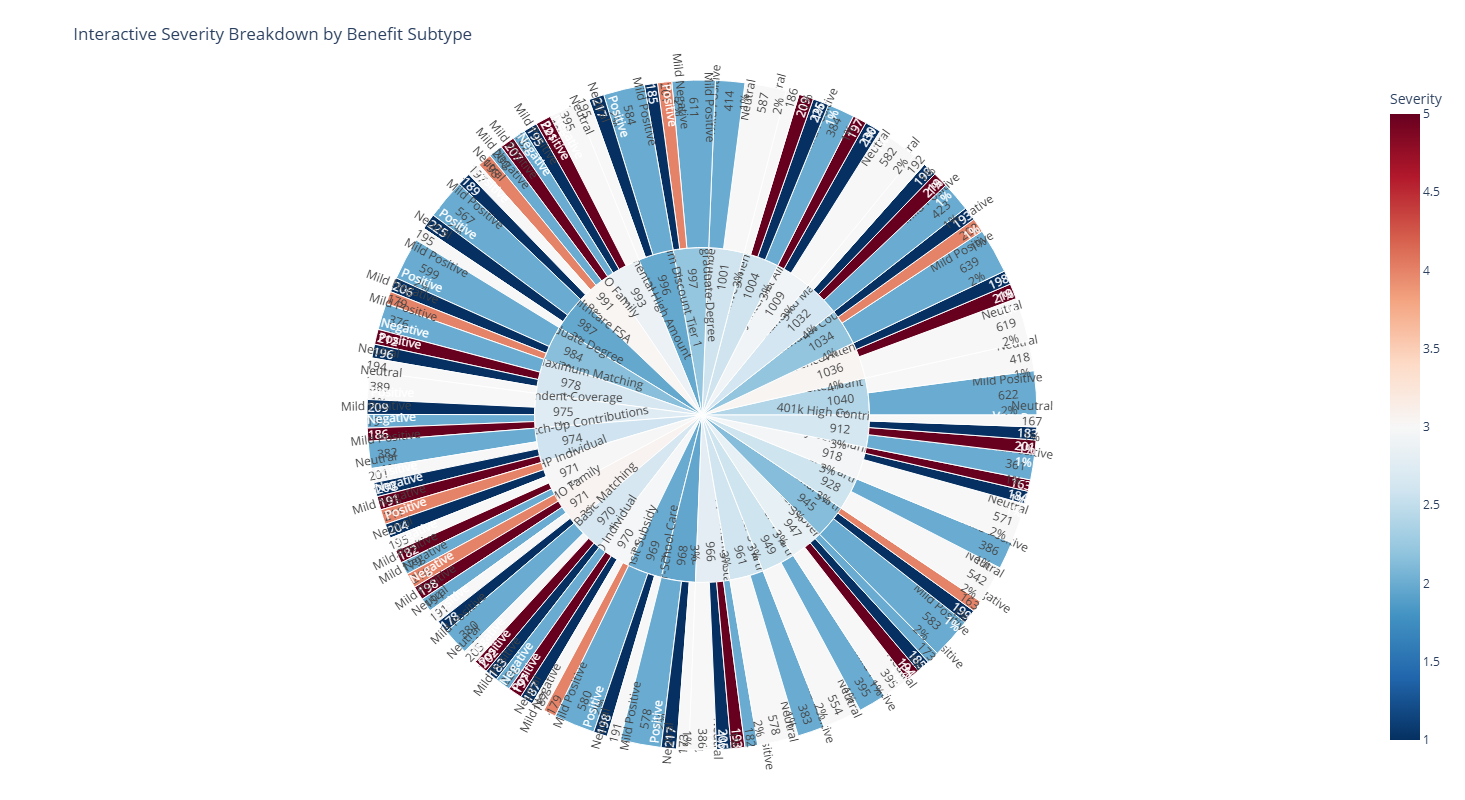

In [34]:
import pandas as pd
import plotly.express as px

# Step 1: Aggregate severity counts per BenefitSubType
severity_breakdown = df.groupby(['BenefitSubType', 'Severity']).size().reset_index(name='Count')

# Step 2: Map severity numbers to readable labels
severity_labels = {
    1: "Very Positive",
    2: "Mild Positive",
    3: "Neutral",
    4: "Mild Negative",
    5: "Very Negative"
}
severity_breakdown['SeverityLabel'] = severity_breakdown['Severity'].map(severity_labels)

# Step 3: Build the sunburst chart
fig = px.sunburst(
    severity_breakdown,
    path=['BenefitSubType', 'SeverityLabel'],
    values='Count',
    color='Severity',
    color_continuous_scale='RdBu_r',
    title='Interactive Severity Breakdown by Benefit Subtype',
    height=800,  # increase overall size
    width=1000
)

# Improve readability
fig.update_traces(
    textinfo='label+percent entry+value',
    insidetextorientation='radial'
)
fig.update_layout(
    margin=dict(t=80, l=50, r=50, b=50),
    uniformtext=dict(minsize=12, mode='show')
)

fig.show()


In [36]:
!pip install streamlit

  Using cached gitpython-3.1.45-py3-none-any.whl.metadata (13 kB)
  Using cached gitdb-4.0.12-py3-none-any.whl.metadata (1.2 kB)
  Using cached smmap-5.0.2-py3-none-any.whl.metadata (4.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 113.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.2/731.2 kB 94.5 MB/s eta 0:00:00
Using cached gitpython-3.1.45-py3-none-any.whl (208 kB)
Using cached gitdb-4.0.12-py3-none-any.whl (62 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 179.4 MB/s eta 0:00:00
Using cached smmap-5.0.2-py3-none-any.whl (24 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7 [streamlit]/7 [streamlit]


In [37]:
import streamlit as st
import pandas as pd
import plotly.express as px

# === Load your dataset ===
# You can modify this path or use st.file_uploader for user uploads
df = pd.read_csv("feedback_parallel_output.csv")

# === Map severity numbers to readable labels ===
severity_labels = {
    1: "Very Positive",
    2: "Mild Positive",
    3: "Neutral",
    4: "Mild Negative",
    5: "Very Negative"
}
df['SeverityLabel'] = df['Severity'].map(severity_labels)

st.title("🔍 Severity Breakdown by Benefit Type and Subtype")

# === Plot 1: BenefitType ===
st.subheader("Severity Breakdown by BenefitType")

type_data = df.groupby(['BenefitType', 'SeverityLabel']).size().reset_index(name='Count')

fig1 = px.sunburst(
    type_data,
    path=['BenefitType', 'SeverityLabel'],
    values='Count',
    color='Count',
    color_continuous_scale='RdBu_r',
    title='BenefitType → Severity',
    height=600,
    width=800
)
fig1.update_traces(textinfo="label+percent entry+value")

st.plotly_chart(fig1, use_container_width=True)


# === Plot 2: BenefitSubType ===
st.subheader("Severity Breakdown by BenefitSubType")

subtype_data = df.groupby(['BenefitSubType', 'SeverityLabel']).size().reset_index(name='Count')

fig2 = px.sunburst(
    subtype_data,
    path=['BenefitSubType', 'SeverityLabel'],
    values='Count',
    color='Count',
    color_continuous_scale='RdBu_r',
    title='BenefitSubType → Severity',
    height=600,
    width=800
)
fig2.update_traces(textinfo="label+percent entry+value")

st.plotly_chart(fig2, use_container_width=True)


2025-08-22 13:12:04.651 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-22 13:12:04.912 
  command:

    streamlit run /home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/ipykernel_launcher.py [ARGUMENTS]
2025-08-22 13:12:04.912 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-22 13:12:04.913 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-22 13:12:04.913 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-22 13:12:04.914 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-22 13:12:04.914 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-22 13:12:04.992

DeltaGenerator()